In [190]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from ops.os_operation import mkdir
import shutil
import  numpy as np
from data_processing.Prepare_Input import Prepare_Input
from data_processing.Single_Dataset import Single_Dataset
from torch.utils.data import DataLoader
from data_processing.collate_fn import collate_fn_Jake
import pickle

In [41]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
from multiprocessing import Pool
from model.layers import GAT_gate

N_atom_features = 28

class GNN_Model(nn.Module):
    def __init__(self, params):
        super(GNN_Model, self).__init__()
        n_graph_layer = params['n_graph_layer']
        d_graph_layer = params['d_graph_layer']
        n_FC_layer = params['n_FC_layer']
        d_FC_layer = params['d_FC_layer']
        self.dropout_rate = params['dropout_rate']


        self.layers1 = [d_graph_layer for i in range(n_graph_layer +1)]
        self.gconv1 = nn.ModuleList \
            ([GAT_gate(self.layers1[i], self.layers1[ i +1]) for i in range(len(self.layers1 ) -1)])

#         Original
#         self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], d_FC_layer) if i== 0 else
#                                  nn.Linear(d_FC_layer, 1) if i == n_FC_layer - 1 else
#                                  nn.Linear(d_FC_layer, d_FC_layer) for i in range(n_FC_layer)])

#         Jake params 1
#         self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], 300),
#                                  nn.Linear(300, 200),
#                                  nn.Linear(200, 1)
#                                  ])

#         Jake params 2
        self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], 2048),
                                 nn.Linear(2048, 512),
                                 nn.Linear(512, 256),
                                 nn.Linear(256, 1)
                                 ])

#         Jake params 3
#         self.FC = nn.ModuleList([nn.Linear(self.layers1[-1], 2048),
#                                  nn.Linear(2048, 512),
#                                  nn.Linear(512, 256),
#                                  nn.Linear(256, 1)
#                                  ])

        self.mu = nn.Parameter(torch.Tensor([params['initial_mu']]).float())
        self.dev = nn.Parameter(torch.Tensor([params['initial_dev']]).float())
        #self.embede = nn.Linear(2 * N_atom_features, d_graph_layer, bias=False)
        self.params=params



    def fully_connected(self, c_hs):
        regularization = torch.empty(len(self.FC) * 1 - 1, device=c_hs.device)
        act_fn = nn.LeakyReLU(0.2)

        for k in range(len(self.FC)):
            # c_hs = self.FC[k](c_hs)
            if k < len(self.FC) - 1:
                c_hs = self.FC[k](c_hs)
                c_hs = F.dropout(c_hs, p=self.dropout_rate, training=self.training)
                # c_hs = F.relu(c_hs)
                c_hs = act_fn(c_hs)
            else:
                c_hs = self.FC[k](c_hs)

        c_hs = torch.sigmoid(c_hs)

        return c_hs
    def Formulate_Adj2(self,c_adjs2,c_valid,atom_list,device):
        study_distance = c_adjs2.clone().detach().to(device)  # only focused on where there exist atoms, ignore the area filled with 0
        study_distance = torch.exp(-torch.pow(study_distance - self.mu.expand_as(study_distance), 2) / self.dev)
        filled_value = torch.Tensor([0]).expand_as(study_distance).to(device)
        for batch_idx in range(len(c_adjs2)):
            num_atoms = int(atom_list[batch_idx])
            count_receptor = len(c_valid[batch_idx].nonzero())
            c_adjs2[batch_idx,:count_receptor,count_receptor:num_atoms]=torch.where(c_adjs2[batch_idx,:count_receptor,count_receptor:num_atoms]<=20,study_distance[batch_idx,:count_receptor,count_receptor:num_atoms],filled_value[batch_idx,:count_receptor,count_receptor:num_atoms])
            c_adjs2[batch_idx,count_receptor:num_atoms,:count_receptor]=c_adjs2[batch_idx,:count_receptor,count_receptor:num_atoms].t()
        return c_adjs2

    def get_attention_weight(self,data):
        c_hs, c_adjs1, c_adjs2 = data
        atten1,c_hs1 = self.gconv1[0](c_hs, c_adjs1,request_attention=True)  # filled 0 part will not effect other parts
        atten2,c_hs2 = self.gconv1[0](c_hs, c_adjs2,request_attention=True)
        return atten1,atten2
    def embede_graph(self, data):
        """

        :param data:
        :return: c_hs:batch_size*max_atoms
        """
        c_hs, c_adjs1, c_adjs2= data
        regularization = torch.empty(len(self.gconv1), device=c_hs.device)

        for k in range(len(self.gconv1)):
            c_hs1 = self.gconv1[k](c_hs, c_adjs1)#filled 0 part will not effect other parts
            c_hs2 = self.gconv1[k](c_hs, c_adjs2)
            c_hs = c_hs2 - c_hs1
            c_hs = F.dropout(c_hs, p=self.dropout_rate, training=self.training)
        #c_hs = c_hs.sum(1)
        return c_hs
    def Get_Prediction(self,c_hs,atom_list):
        prediction=[]
        for batch_idx in range(len(atom_list)):
            num_atoms = int(atom_list[batch_idx])
            tmp_pred=c_hs[batch_idx,:num_atoms]
            
            ## POOLING METHOD:
            # tmp_pred=tmp_pred.sum(0)#sum all the used atoms
            tmp_pred=tmp_pred.mean(0) ## Average all the used atoms
            
            
            #if self.params['debug']:
            #    print("pred feature size",tmp_pred.size())
            prediction.append(tmp_pred)
        prediction = torch.stack(prediction, 0)
        return prediction
    def train_model(self,data,device):
        #get data
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2=self.Formulate_Adj2(c_adjs2,c_valid,num_atoms,device)
        #then do the gate
        c_hs=self.embede_graph((c_hs,c_adjs1,c_adjs2))
        #if self.params['debug']:
        #    print("embedding size",c_hs.size())
        #sum based on the atoms
        c_hs=self.Get_Prediction(c_hs,num_atoms)
        c_hs = self.fully_connected(c_hs)
        c_hs = c_hs.view(-1)
        return c_hs
    def test_model(self, data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms,device)
        # then do the gate
        c_hs = self.embede_graph((c_hs, c_adjs1, c_adjs2))
        # sum based on the atoms
        c_hs = self.Get_Prediction(c_hs, num_atoms)
        c_hs = self.fully_connected(c_hs)
        c_hs = c_hs.view(-1)
        return c_hs
    def test_model_final(self,data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms, device)
        attention1, attention2 = self.get_attention_weight((c_hs, c_adjs1, c_adjs2))
        # then do the gate
        c_hs = self.embede_graph((c_hs, c_adjs1, c_adjs2))
        # sum based on the atoms
        c_hs = self.Get_Prediction(c_hs, num_atoms)
        c_hs = self.fully_connected(c_hs)
        c_hs = c_hs.view(-1)
        return c_hs,attention1,attention2
    def eval_model_attention(self,data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms, device)
        attention1,attention2 = self.get_attention_weight((c_hs, c_adjs1, c_adjs2))
        return attention1,attention2
    def feature_extraction(self,c_hs):
        for k in range(len(self.FC)):
                # c_hs = self.FC[k](c_hs)
            if k < len(self.FC) - 1:
                c_hs = self.FC[k](c_hs)
                c_hs = F.dropout(c_hs, p=self.dropout_rate, training=False)
                c_hs = F.relu(c_hs)

            return c_hs
    def model_gnn_feature(self, data,device):
        c_hs, c_adjs1, c_adjs2, c_valid, num_atoms = data
        #c_hs = self.embede(c_hs)
        c_adjs2 = self.Formulate_Adj2(c_adjs2, c_valid, num_atoms,device)
        # then do the gate
        c_hs = self.embede_graph((c_hs, c_adjs1, c_adjs2))
        # sum based on the atoms
        c_hs = self.Get_Prediction(c_hs, num_atoms)
        #c_hs = self.fully_connected(c_hs)
        #c_hs = c_hs.view(-1)
        c_hs=self.feature_extraction(c_hs)
        return c_hs

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_model(model, device, load_save_file=False):
    if load_save_file:
        model.load_state_dict(torch.load(load_save_file))
    else:
        for param in model.parameters():
            if param.dim() == 1:
                continue
                nn.init.constant(param, 0)
            else:
                #nn.init.normal(param, 0.0, 0.15)
                nn.init.xavier_normal_(param)

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model)
    model.to(device)
    return model

def init_model(model_path,params):
    model = GNN_Model(params)
    print('    Total params: %.10fM' % (count_parameters(model) / 1000000.0))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = initialize_model(model, device)
    state_dict = torch.load(model_path, map_location = device)
    model.load_state_dict(state_dict)
    model.eval()
    return model,device

In [47]:
def Get_Predictions(dataloader,device,model):
    Final_pred = []
    total_Y = []
    with torch.no_grad():
        for batch_idx, sample in enumerate(dataloader):
            H, A1, A2, V, Y, Atom_count = sample
            batch_size = H.size(0)
            H, A1, A2, V = H.to(device), A1.to(device), A2.to(device), V.to(device)
            pred= model.test_model((H, A1, A2, V, Atom_count), device)
            pred1 = pred.detach().cpu().numpy()
            Final_pred += list(pred1)
            total_Y += list(Y)
    return total_Y, Final_pred

def test_falcon_gnn(input_path, params, model_path):
    '''
    Trains the GNN according to Jake's parameters.
    FALCON_GNN stands for Fucking Awesome Linking
    Cohort Of Nottingham, which I just made up
    '''
    ## Get all the NPZ files from the input_path

    list_npz = [f for f in listdir(input_path) if isfile(join(input_path, f)) and f.endswith(".npz")]
    fold1_label = ['1a2k', '1e96', '1he1', '1he8', '1wq1', '1f6m', '1ma9', '2btf', '1g20', '1ku6', '1t6g', '1ugh', '1yvb', '2ckh', '3pro']
    fold2_label = ['1akj', '1p7q', '2bnq', '1dfj', '1nbf', '1r4m', '1xd3', '2bkr', '1gpw', '1hxy', '1u7f', '1uex', '1zy8', '2goo', '1ewy']
    fold3_label = ['1avw', '1bth', '1bui', '1cho', '1ezu', '1ook', '1oph', '1ppf', '1tx6', '1xx9', '2fi4', '2kai', '1r0r', '2sni', '3sic']
    fold4_label = ['1bvn', '1tmq', '1f51', '1fm9', '1a2y', '1g6v', '1gpq', '1jps', '1wej', '1l9b', '1s6v', '1w1i', '2a5t', '3fap']

    train_data_list = []
    test_data_list = []
    print(len(list_npz))
    for file in list_npz:
        if file[:4] in fold1_label or file[:4] in fold2_label or file[:4] in fold4_label:
            train_data_list.append(file)
        elif file[:4] in fold3_label:
            test_data_list.append(file)
    
    ## Just to test it out
#     test_data_list = test_data_list[:120]
    
    train_data = Single_Dataset(train_data_list)
    test_data = Single_Dataset(test_data_list)
    #train_data, test_data = random_split(dataset, [0.75, 0.25])

    BATCH_SIZE = 10

    train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=False,
                            num_workers=params['num_workers'],
                            drop_last=False, collate_fn=collate_fn_Jake)

    test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False,
                            num_workers=params['num_workers'],
                            drop_last=False, collate_fn=collate_fn_Jake)

    ## Initialize Model from saved state
    
    model, device = init_model(model_path, params)
    
    ## Get predictions for the model
    
    os.chdir(input_path)
    Y, Final_Pred = Get_Predictions(test_loader, device, model)
     
    return test_data_list, Final_Pred, Y

## Actually testing the model

In [10]:
## Original DOVE GNN Parameters

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 4,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_orig_params.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list, preds, y = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 8.5652550000M


In [16]:
## Jake Parameters 1

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_1.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_1, preds_1, y_1 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 6.6685780000M


In [20]:
## Jake Parameters 2

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_2, preds_2, y_2 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


In [22]:
## Jake Parameters 3

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_3.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_3, preds_3, y_3 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


## Assessing the Top Ranks of the Models

In [34]:
## Some functions to help with everything
def get_ordered_list(test_list, preds, y):
    '''
    Works to get the ordered and grouped list 
    to make analysis easier
    '''
    curr_pdb = ''
    ordered_test_list = []
    temp_pdb_list = []
    for i,ele in enumerate(test_list):
        if ele[:4] != curr_pdb:
            ## Reset the vars for the next pdb set
            curr_pdb = ele[:4]
            temp_pdb_list.sort()
            ordered_test_list.append(temp_pdb_list[::-1])
            temp_pdb_list = []
        temp_pdb_list.append((preds[i], ele.split(".")[0], int(y[i])))

    ordered_test_list = ordered_test_list[1:]
    return ordered_test_list

In [35]:
## Getting the top ranks the same way that DOVE_GNN does

def get_ranks(ordered_test_list):
    '''
    Gets the top ranks the same way the DOVE GNN does
    '''
    rank_list = []
    for group in ordered_test_list:
        first_rank = 0
        group_name = group[0][1][:4]
        for i, entry in enumerate(group):
            if entry[2] == 1:
                rank_list.append((group_name, i+1))
                break
    return rank_list

In [36]:
## Calculating the Top Ranks:

orig_ranks = get_ranks(get_ordered_list(test_list, preds, y))
jake1_ranks = get_ranks(get_ordered_list(test_list_1, preds_1, y_1))
jake2_ranks = get_ranks(get_ordered_list(test_list_2, preds_2, y_2))
jake3_ranks = get_ranks(get_ordered_list(test_list_3, preds_3, y_3))

In [37]:
print(orig_ranks)

[('1akj', 1), ('1dfj', 1), ('1ewy', 1), ('1gpw', 1), ('1hxy', 1), ('1nbf', 1), ('1p7q', 1), ('1r4m', 1), ('1u7f', 1), ('1uex', 1), ('1xd3', 1), ('1zy8', 1), ('2bkr', 1), ('2bnq', 1)]


In [38]:
print(jake1_ranks)

[('1akj', 1), ('1dfj', 1), ('1ewy', 1), ('1gpw', 1), ('1hxy', 1), ('1nbf', 1), ('1p7q', 1), ('1r4m', 1), ('1u7f', 1), ('1uex', 1), ('1xd3', 1), ('1zy8', 1), ('2bkr', 1), ('2bnq', 1)]


In [39]:
print(jake2_ranks)

[('1akj', 1), ('1dfj', 79), ('1ewy', 3), ('1gpw', 66), ('1hxy', 1), ('1nbf', 1), ('1p7q', 1), ('1r4m', 6), ('1u7f', 2), ('1uex', 2), ('1xd3', 1), ('1zy8', 3), ('2bkr', 1), ('2bnq', 1)]


In [40]:
print(jake3_ranks)

[('1akj', 2), ('1dfj', 64), ('1ewy', 3), ('1gpw', 19), ('1hxy', 2), ('1nbf', 8), ('1p7q', 1), ('1r4m', 22), ('1u7f', 2), ('1uex', 17), ('1xd3', 6), ('1zy8', 1), ('2bkr', 4), ('2bnq', 1)]


## Looking at Loss

In [48]:
os.chdir("/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/")
loss_orig = pickle.load(open("full_train_DG1_random_batch_orig_params_loss.pickle", "rb"))
loss_jake_1 = pickle.load(open("full_train_DG1_random_batch_jake_params_1_loss.pickle", "rb"))
loss_jake_2 = pickle.load(open("full_train_DG1_random_batch_jake_params_2_loss.pickle", "rb"))
loss_jake_3 = pickle.load(open("full_train_DG1_random_batch_jake_params_3_loss.pickle", "rb"))

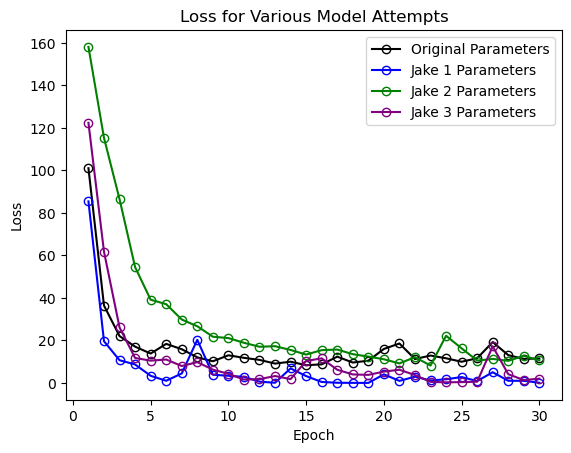

In [50]:
fig, ax = plt.subplots()

x_axis = range(1,31)
ax.plot(x_axis, loss_orig, label = "Original Parameters", color = "black", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_jake_1, label = "Jake 1 Parameters", color = "blue", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_jake_2, label = "Jake 2 Parameters", color = "green", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_jake_3, label = "Jake 3 Parameters", color = "purple", marker = "o", markerfacecolor = "None")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.title("Loss for Various Model Attempts")
plt.legend()

# Looking at the chosen best model repeated with all data folds

## Testing the models on their test sets

In [42]:
## Jake Parameters 2 - Test 1

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/full_train_DG1_random_batch_jake_params_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_1, preds_1, y_1 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


In [44]:
## Jake Parameters 2 - Test 2

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/DG1_random_batch_jake_params_2_run_2.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_2, preds_2, y_2 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


In [46]:
## Jake Parameters 2 - Test 3

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/DG1_random_batch_jake_params_2_run_3.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_3, preds_3, y_3 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


In [48]:
## Jake Parameters 2 - Test 4

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/DG1_random_batch_jake_params_2_run_4.pt"
input_path = "/mnt/d/dockground_1_processed_npz"
test_list_4, preds_4, y_4 = test_falcon_gnn(input_path, params, model_path)

6275
    Total params: 9.5805500000M


In [49]:
## Calculating the Top Ranks:

test1_ranks = get_ranks(get_ordered_list(test_list_1, preds_1, y_1))
test2_ranks = get_ranks(get_ordered_list(test_list_2, preds_2, y_2))
test3_ranks = get_ranks(get_ordered_list(test_list_3, preds_3, y_3))
test4_ranks = get_ranks(get_ordered_list(test_list_4, preds_4, y_4))

In [50]:
print(test1_ranks)

[('1akj', 1), ('1dfj', 79), ('1ewy', 3), ('1gpw', 66), ('1hxy', 1), ('1nbf', 1), ('1p7q', 1), ('1r4m', 6), ('1u7f', 2), ('1uex', 2), ('1xd3', 1), ('1zy8', 3), ('2bkr', 1), ('2bnq', 1)]


In [51]:
print(test2_ranks)

[('1a2k', 1), ('1e96', 4), ('1f6m', 1), ('1g20', 1), ('1he1', 1), ('1he8', 1), ('1ku6', 1), ('1ma9', 1), ('1t6g', 1), ('1ugh', 2), ('1wq1', 1), ('1yvb', 1), ('2btf', 1), ('2ckh', 1)]


In [52]:
print(test3_ranks)

[('1a2y', 1), ('1bvn', 15), ('1f51', 1), ('1fm9', 11), ('1g6v', 1), ('1gpq', 3), ('1jps', 1), ('1s6v', 1), ('1tmq', 1), ('1w1i', 1), ('1wej', 1), ('2a5t', 17)]


In [53]:
print(test4_ranks)

[('1avw', 1), ('1bth', 21), ('1bui', 1), ('1cho', 1), ('1ezu', 2), ('1ook', 2), ('1oph', 1), ('1ppf', 1), ('1r0r', 1), ('1tx6', 1), ('1xx9', 16), ('2fi4', 1), ('2kai', 1), ('2sni', 1)]


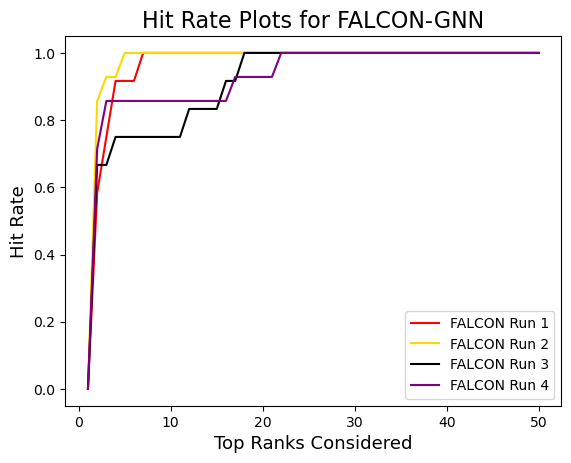

In [65]:
## Plotting the hit rate

def plot_cdf(fig, ax, data, bins, label = None, color = "black"):
    '''
    Plots the CDF
    '''
    count, bins_count = np.histogram(data, bins=bins)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    ax.plot(bins_count[1:], cdf, label=label, color = color)

fig,ax = plt.subplots()
bins = list(range(0, 51))
plot_cdf(fig, ax, [ele[1] for ele in test1_ranks], bins, label = "FALCON Run 1", color = "red")
plot_cdf(fig, ax, [ele[1] for ele in test2_ranks], bins, label = "FALCON Run 2", color = "gold")
plot_cdf(fig, ax, [ele[1] for ele in test3_ranks], bins, label = "FALCON Run 3", color = "black")
plot_cdf(fig, ax, [ele[1] for ele in test4_ranks], bins, label = "FALCON Run 4", color = "purple")

plt.ylabel("Hit Rate", fontsize = 13)
plt.xlabel("Top Ranks Considered", fontsize = 13)
plt.title("Hit Rate Plots for FALCON-GNN", fontsize = 16)
plt.legend()

In [74]:
## Reading in Data from original figure


def read_in_csv(csv_file):
    X, Y = [], []
    for line in open(csv_file, "r"):
        temp_x, temp_y = round(float(line.split(",")[0])), float(line.split(",")[1])
        X.append(temp_x)
        Y.append(temp_y)
    Y[0] = 0
    return X,Y

os.chdir("/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/")

a_x, a_y = read_in_csv("dove_GNN_fig_A.csv")
b_x, b_y = read_in_csv("dove_GNN_fig_B.csv")
c_x, c_y = read_in_csv("dove_GNN_fig_C.csv")
d_x, d_y = read_in_csv("dove_GNN_fig_D.csv")

In [75]:
print(a_y)

[0, 0.732163743, 0.730359235, 0.800734766, 0.804343781, 0.867501315, 0.867501315]


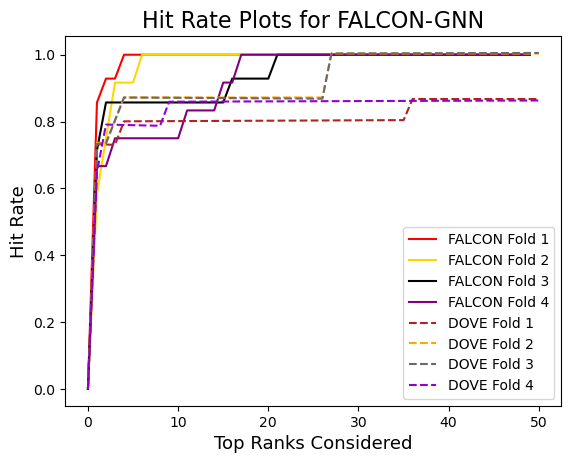

In [83]:
## Plotting the hit rate

def plot_cdf(fig, ax, data, bins, label = None, color = "black"):
    '''
    Plots the CDF
    '''
    count, bins_count = np.histogram(data, bins=bins)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    ax.plot(bins_count[:-1], cdf, label=label, color = color)

fig,ax = plt.subplots()
bins = list(range(0, 51))
plot_cdf(fig, ax, [ele[1] for ele in test2_ranks], bins, label = "FALCON Fold 1", color = "red")
plot_cdf(fig, ax, [ele[1] for ele in test1_ranks], bins, label = "FALCON Fold 2", color = "gold")
plot_cdf(fig, ax, [ele[1] for ele in test4_ranks], bins, label = "FALCON Fold 3", color = "black")
plot_cdf(fig, ax, [ele[1] for ele in test3_ranks], bins, label = "FALCON Fold 4", color = "purple")

ax.plot(a_x, a_y, label = "DOVE Fold 1", color = "firebrick", linestyle = "--")
ax.plot(b_x, b_y, label = "DOVE Fold 2", color = "orange", linestyle = "--")
ax.plot(c_x, c_y, label = "DOVE Fold 3", color = "dimgray", linestyle = "--")
ax.plot(d_x, d_y, label = "DOVE Fold 4", color = "darkviolet", linestyle = "--")
        
plt.ylabel("Hit Rate", fontsize = 13)
plt.xlabel("Top Ranks Considered", fontsize = 13)
plt.title("Hit Rate Plots for FALCON-GNN", fontsize = 16)
plt.legend()

In [79]:
[ele[1] for ele in test2_ranks]

[1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]

In [84]:
os.chdir("/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/")
loss_test_1 = pickle.load(open("DG1_random_batch_jake_params_2_run_2_loss.pickle", "rb"))
loss_test_2 = pickle.load(open("full_train_DG1_random_batch_jake_params_2_loss.pickle", "rb"))
loss_test_3 = pickle.load(open("DG1_random_batch_jake_params_2_run_4_loss.pickle", "rb"))
loss_test_4 = pickle.load(open("DG1_random_batch_jake_params_2_run_3_loss.pickle", "rb"))

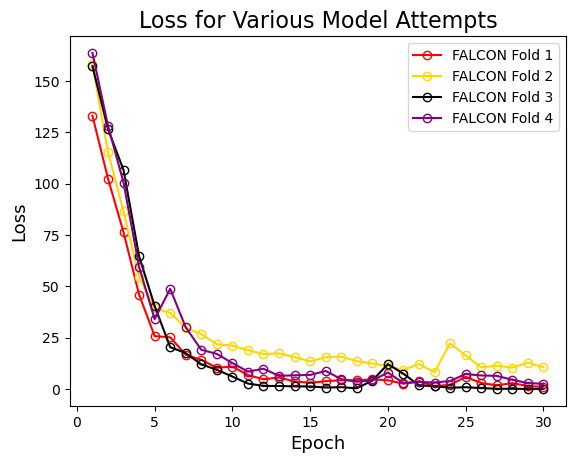

In [88]:
fig, ax = plt.subplots()

x_axis = range(1,31)
ax.plot(x_axis, loss_test_1, label = "FALCON Fold 1", color = "red", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_test_2, label = "FALCON Fold 2", color = "gold", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_test_3, label = "FALCON Fold 3", color = "black", marker = "o", markerfacecolor = "None")
ax.plot(x_axis, loss_test_4, label = "FALCON Fold 4", color = "purple", marker = "o", markerfacecolor = "None")
plt.xlabel("Epoch", fontsize = 13)
plt.ylabel("Loss", fontsize = 13)
plt.title("Loss for Various Model Attempts", fontsize = 16)
plt.legend()

## Getting the average rank for the acceptable models

In [115]:
ordered_1 = get_ordered_list(test_list_2, preds_2, y_2)
ordered_2 = get_ordered_list(test_list_1, preds_1, y_1)
ordered_3 = get_ordered_list(test_list_4, preds_4, y_4)
ordered_4 = get_ordered_list(test_list_3, preds_3, y_3)

def get_average_acceptable_rank(ordered_list):
    '''
    Gets the average rank of acceptable models for each 
    individual target class
    '''
    average_ranks = []
    for group in ordered_list:
        temp_avg = []
        temp_name = ''
        for i, decoy in enumerate(group):
            if decoy[2] == 1:
                ## The structure is acceptable
                temp_avg.append(i)
                temp_name = decoy[1][:4]
                print(temp_avg, temp_name)
        average_ranks.append((temp_name, sum(temp_avg)/len(temp_avg)))
        print(average_ranks)
    return average_ranks

In [105]:
avg_rank_1 = get_average_acceptable_rank(ordered_1)

[0] 1hxy
[0, 1] 1hxy
[('1hxy', 0.5)]


In [103]:
print(avg_rank_1)

[('1akj', 4.9), ('1dfj', 93.6), ('1ewy', 35.3), ('1gpw', 88.0), ('1hxy', 0.5), ('1nbf', 11.6), ('1p7q', 1.75), ('1r4m', 5.0), ('1u7f', 23.636363636363637), ('1uex', 1.0), ('1xd3', 7.1), ('1zy8', 35.3), ('2bkr', 9.818181818181818), ('2bnq', 0.0)]


In [166]:
## What about the percent acceptable model in the top 25 ranks?? -> That might be an easier metric that is less
## Prone to bias based on the number of acceptable models per target!

def get_top_x_percent_rank(ordered_list, x_rank = 25):
    '''
    Gets the percent of acceptable structures in the 
    top 25 ranks from the algorithm! Also does a
    weighted average so that strutures with more
    acceptable decoys are weighted a bit higher
    since they are better examples of the code
    working properly
    '''
    percent_list = []
    for group in ordered_list:
        temp_acceptable = []
        temp_name = ''
        for i, decoy in enumerate(group):
            if decoy[2] == 1:
                ## The structure is acceptable
                temp_acceptable.append(i)
                temp_name = decoy[1][:4]
        percent_list.append((temp_name, len([num for num in temp_acceptable if num <= (x_rank-1)])/len(temp_acceptable), len(temp_acceptable)))
    return percent_list

In [124]:
top_25_1 = get_top_x_percent_rank(ordered_1)
top_25_2 = get_top_x_percent_rank(ordered_2)
top_25_3 = get_top_x_percent_rank(ordered_3)
top_25_4 = get_top_x_percent_rank(ordered_4)

In [125]:
print(top_25_1)

[('1a2k', 1.0, 2), ('1e96', 0.7, 10), ('1f6m', 0.7, 10), ('1g20', 1.0, 10), ('1he1', 0.5384615384615384, 13), ('1he8', 1.0, 1), ('1ku6', 1.0, 10), ('1ma9', 0.9, 10), ('1t6g', 0.4, 65), ('1ugh', 0.25, 12), ('1wq1', 0.75, 12), ('1yvb', 1.0, 11), ('2btf', 1.0, 10), ('2ckh', 1.0, 10)]


In [169]:
def get_weighted_average(top_25):
    '''
    Quick helper fxn
    '''
    final_mean = []
    for ele in top_25:
        final_mean += [ele[1]]*ele[2]
    return np.mean(final_mean)

print(f"Average percent of acceptable models in top 25 ranks for Fold 1: {get_weighted_average(top_25_1)}")
print(f"Average percent of acceptable models in top 25 ranks for Fold 2: {get_weighted_average(top_25_2)}")
print(f"Average percent of acceptable models in top 25 ranks for Fold 3: {get_weighted_average(top_25_3)}")
print(f"Average percent of acceptable models in top 25 ranks for Fold 4: {get_weighted_average(top_25_4)}")

Average percent of acceptable models in top 25 ranks for Fold 1: 0.6559139784946237
Average percent of acceptable models in top 25 ranks for Fold 2: 0.5596330275229358
Average percent of acceptable models in top 25 ranks for Fold 3: 0.968503937007874
Average percent of acceptable models in top 25 ranks for Fold 4: 0.7549019607843137


In [192]:
top_50_1 = get_top_x_percent_rank(ordered_1, x_rank = 50)
top_50_2 = get_top_x_percent_rank(ordered_2, x_rank = 50)
top_50_3 = get_top_x_percent_rank(ordered_3, x_rank = 50)
top_50_4 = get_top_x_percent_rank(ordered_4, x_rank = 50)

print(f"Average percent of acceptable models in top 50 ranks for Fold 1: {get_weighted_average(top_50_1)}")
print(f"Average percent of acceptable models in top 50 ranks for Fold 2: {get_weighted_average(top_50_2)}")
print(f"Average percent of acceptable models in top 50 ranks for Fold 3: {get_weighted_average(top_50_3)}")
print(f"Average percent of acceptable models in top 50 ranks for Fold 4: {get_weighted_average(top_50_4)}")

Average percent of acceptable models in top 50 ranks for Fold 1: 0.8225806451612904
Average percent of acceptable models in top 50 ranks for Fold 2: 0.6788990825688074
Average percent of acceptable models in top 50 ranks for Fold 3: 0.968503937007874
Average percent of acceptable models in top 50 ranks for Fold 4: 0.8725490196078431


In [193]:
top_50_1 = get_top_x_percent_rank(ordered_1, x_rank = 10)
top_50_2 = get_top_x_percent_rank(ordered_2, x_rank = 10)
top_50_3 = get_top_x_percent_rank(ordered_3, x_rank = 10)
top_50_4 = get_top_x_percent_rank(ordered_4, x_rank = 10)

print(f"Average percent of acceptable models in top 10 ranks for Fold 1: {get_weighted_average(top_50_1)}")
print(f"Average percent of acceptable models in top 10 ranks for Fold 2: {get_weighted_average(top_50_2)}")
print(f"Average percent of acceptable models in top 10 ranks for Fold 3: {get_weighted_average(top_50_3)}")
print(f"Average percent of acceptable models in top 10 ranks for Fold 4: {get_weighted_average(top_50_4)}")

Average percent of acceptable models in top 10 ranks for Fold 1: 0.41935483870967744
Average percent of acceptable models in top 10 ranks for Fold 2: 0.36697247706422004
Average percent of acceptable models in top 10 ranks for Fold 3: 0.7559055118110237
Average percent of acceptable models in top 10 ranks for Fold 4: 0.6176470588235294


# Testing the model on the Dockground Set 2 Dataset

NOTE: If you are running this code, make sure that you modify the 'input_path' and 'model_path' for each of the folds to match wherever you stored the data on your own computer so that the code will run properly. Once those have been properly configured, you can run all of the code cells to get the output I got for Dockground Set 2 in the paper. 

In [133]:
def test_falcon_gnn_set2(input_path, params, model_path):
    '''
    For testing the Dockground set 2 dataset
    '''
    ## Get all the NPZ files from the input_path

    list_npz = [f for f in listdir(input_path) if isfile(join(input_path, f)) and f.endswith(".npz")]
    
    test_data = Single_Dataset(list_npz)

    BATCH_SIZE = 10


    test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False,
                            num_workers=params['num_workers'],
                            drop_last=False, collate_fn=collate_fn_Jake)

    ## Initialize Model from saved state
    
    model, device = init_model(model_path, params)
    
    ## Get predictions for the model
    
    os.chdir(input_path)
    Y, Final_Pred = Get_Predictions(test_loader, device, model)
     
    return list_npz, Final_Pred, Y

In [195]:
## Jake Parameters 2 - Test 1

params = {
    'F' : 'example',
    'mode' : '3',
    'gpu' : '0',
    'batch_size' : 32,
    'num_workers' : 7,
    'n_graph_layer' : 3,
    'd_graph_layer' : 1024,
    'n_FC_layer' : 4,
    'd_FC_layer' : 128,
    'initial_mu' : 0.0,
    'initial_dev' : 1.0,
    'dropout_rate' : 0.3,
    'seed' : 888,
    'fold' : -1,
    'receptor_units' : 1,
}


model_path = "/mnt/c/Users/jaket/Documents/GitHub/GNN_DOVE/best_model/FALCON_GNN_Fold_2_model.pt"
input_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/dockground_set_2_npz"
set_2_list_1, set_2_preds_1, set_2_y_1 = test_falcon_gnn_set2(input_path, params, model_path)

    Total params: 9.5805500000M


In [198]:
## Jake Parameters 2 - Test 2

model_path = "/mnt/c/Users/jaket/Documents/GitHub/GNN_DOVE/best_model/FALCON_GNN_Fold_1_model.pt"
input_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/dockground_set_2_npz"
set_2_list_2, set_2_preds_2, set_2_y_2 = test_falcon_gnn_set2(input_path, params, model_path)

    Total params: 9.5805500000M


In [199]:
## Jake Parameters 2 - Test 3

model_path = "/mnt/c/Users/jaket/Documents/GitHub/GNN_DOVE/best_model/FALCON_GNN_Fold_4_model.pt"
input_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/dockground_set_2_npz"
set_2_list_3, set_2_preds_3, set_2_y_3 = test_falcon_gnn_set2(input_path, params, model_path)

    Total params: 9.5805500000M


In [200]:
## Jake Parameters 2 - Test 4

model_path = "/mnt/c/Users/jaket/Documents/GitHub/GNN_DOVE/best_model/FALCON_GNN_Fold_3_model.pt"
input_path = "/mnt/c/Users/jaket/Documents/GNN_DOVE_DATA/dockground_set_2_npz"
set_2_list_4, set_2_preds_4, set_2_y_4 = test_falcon_gnn_set2(input_path, params, model_path)

    Total params: 9.5805500000M


In [201]:
## Getting the models grouped logically

def get_set2_groups(set_list, preds, y):
    '''
    Groups set 2 into subsets of 7 structures for analysis
    '''
    group_list = []
    group_name = set_list[0][:4]
    temp_list = []
    for i, file in enumerate(set_list):
        if i%7 == 0 and i != 0:
            ## Logic for a new subset
            group_name = file
            temp_list.sort()
            temp_list = temp_list[::-1]
            group_list.append(temp_list)
            temp_list = []
        temp_list.append((preds[i], file, y[i]))
    return group_list
        

In [202]:
ordered_set2_2 = get_set2_groups(set_2_list_1, set_2_preds_1, set_2_y_1)
ordered_set2_1 = get_set2_groups(set_2_list_2, set_2_preds_2, set_2_y_2)
ordered_set2_4 = get_set2_groups(set_2_list_3, set_2_preds_3, set_2_y_3)
ordered_set2_3 = get_set2_groups(set_2_list_4, set_2_preds_4, set_2_y_4)

In [203]:
## Get the percent of models in the top 4

top_4_1 = get_top_x_percent_rank(ordered_set2_1, x_rank = 3)
top_4_2 = get_top_x_percent_rank(ordered_set2_2, x_rank = 3)
top_4_3 = get_top_x_percent_rank(ordered_set2_3, x_rank = 3)
top_4_4 = get_top_x_percent_rank(ordered_set2_4, x_rank = 3)


In [204]:
print(f"Average percent of acceptable models in top 3 ranks for Fold 1: {get_weighted_average(top_4_1)}")
print(f"Average percent of acceptable models in top 3 ranks for Fold 2: {get_weighted_average(top_4_2)}")
print(f"Average percent of acceptable models in top 3 ranks for Fold 3: {get_weighted_average(top_4_3)}")
print(f"Average percent of acceptable models in top 3 ranks for Fold 4: {get_weighted_average(top_4_4)}")

Average percent of acceptable models in top 3 ranks for Fold 1: 0.49230769230769234
Average percent of acceptable models in top 3 ranks for Fold 2: 0.48923076923076925
Average percent of acceptable models in top 3 ranks for Fold 3: 0.49230769230769234
Average percent of acceptable models in top 3 ranks for Fold 4: 0.5


In [205]:
print(ordered_set2_2[0])

[(0.73475754, '1a9n0A_4AB.npz', tensor(0.)), (0.64594465, '1a9n0A_5AB.npz', tensor(0.)), (0.10484636, '1a9n0A_6AB.npz', tensor(0.)), (0.028357565, '1a9n0A_3AB.npz', tensor(1.)), (0.0015427691, '1a9n0A_2AB.npz', tensor(1.)), (0.00062141416, '1a9n0A_1AB.npz', tensor(1.)), (0.00038021334, '1a9n0A_0AB.npz', tensor(1.))]


In [206]:
## In this case I have a best model, so I could go ahead and see the accuracy of the program predicting the 'best' model

def get_best_model_acc(ordered_set):
    '''
    Checks to see if the ordered set contains the top
    ranked model for set 2
    '''
    num_list = []
    for group in ordered_set:
        if group[0][1][7] == "0":
            ## It is the best ranking model for the group
            num_list.append(1)
        else:
            num_list.append(0)
    return(np.mean(num_list))

In [207]:
acc_1 = get_best_model_acc(ordered_set2_1)
acc_2 = get_best_model_acc(ordered_set2_2)
acc_3 = get_best_model_acc(ordered_set2_3)
acc_4 = get_best_model_acc(ordered_set2_4)

In [208]:
print(f"Accuracy of scoring best model first for Fold 1: {acc_1}")
print(f"Accuracy of scoring best model first for Fold 2: {acc_2}")
print(f"Accuracy of scoring best model first for Fold 3: {acc_3}")
print(f"Accuracy of scoring best model first for Fold 4: {acc_4}")

Accuracy of scoring best model first for Fold 1: 0.26993865030674846
Accuracy of scoring best model first for Fold 2: 0.20245398773006135
Accuracy of scoring best model first for Fold 3: 0.2392638036809816
Accuracy of scoring best model first for Fold 4: 0.2147239263803681


In [209]:
## Checking to see what percent has all 4 in the top 4 - any order!
## Showing that the acceptable models are consistently scored better than the unacceptable models

acc_top_4_1 = get_top_x_percent_rank(ordered_set2_1, x_rank = 4)
acc_top_4_2 = get_top_x_percent_rank(ordered_set2_2, x_rank = 4)
acc_top_4_3 = get_top_x_percent_rank(ordered_set2_3, x_rank = 4)
acc_top_4_4 = get_top_x_percent_rank(ordered_set2_4, x_rank = 4)

print(f"Accuracy for all 4 models being in the top 4 for Fold 1 {sum([1 for ele in acc_top_4_1 if ele[1] == 1])/len(acc_top_4_1)}")
print(f"Accuracy for all 4 models being in the top 4 for Fold 2 {sum([1 for ele in acc_top_4_2 if ele[1] == 1])/len(acc_top_4_2)}")
print(f"Accuracy for all 4 models being in the top 4 for Fold 3 {sum([1 for ele in acc_top_4_3 if ele[1] == 1])/len(acc_top_4_3)}")
print(f"Accuracy for all 4 models being in the top 4 for Fold 4 {sum([1 for ele in acc_top_4_4 if ele[1] == 1])/len(acc_top_4_4)}")

Accuracy for all 4 models being in the top 4 for Fold 1 0.12269938650306748
Accuracy for all 4 models being in the top 4 for Fold 2 0.13496932515337423
Accuracy for all 4 models being in the top 4 for Fold 3 0.1411042944785276
Accuracy for all 4 models being in the top 4 for Fold 4 0.13496932515337423
